In [1]:
import os, cv2
import numpy as np
import pylab as pl
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as pat

In [14]:
import os, cv2
import numpy as np
from skimage.measure import label, regionprops

class StopSignDetector():

    def __init__(self):
        '''
            Initilize your stop sign detector with the attributes you need,
            e.g., parameters of your classifier
        '''

        self.mean_red = [[96.06214209877389], [195.98988971847388], [110.16503442016577]]
#         self.mean_red = [[74.31598110707675], [209.53935351410396], [107.62441718163704]]
        # self.mean_blue = [[99.85932704052827], [98.44300302904752], [175.32014134123907]]
        self.mean_yellow = [[153.4965087529189], [164.0425092718365], [76.24108873490943]]
        self.mean_black = [[39.90913573962426], [125.14013012423842], [131.4960628668692]]
        # self.mean_white = [[236.14393466024862], [125.90001457153512], [130.07048918372237]]
        self.mean_fake_red = [[140.30234245338872], [122.31818689157842], [121.58589481040055]]


        self.cov_red = [[  3232.40911135, -11132.20292696,   -186.67559589],
                       [-11132.20292696,   1360.52123188,  -7647.95013781],
                       [  -186.67559589,  -7647.95013781,    150.38283229]]
#         self.cov_red =[[864.69802137, -17944.0165999, -1276.44917554],
#                         [-17944.0165999, 648.70902552, -10513.08789638],
#                         [-1276.44917554, -10513.08789638, 60.53564674]]
        self.cov_blue = [[ 5.67506576e+02, -5.58896348e+00, -5.72622245e+03],
                       [-5.58896348e+00,  5.21579559e+01, -5.95613524e+03],
                       [-5.72622245e+03, -5.95613524e+03,  6.93624323e+01]]
        self.cov_yellow = [[  979.68959055,  -112.29872421, -6447.34687934],
                       [ -112.29872421,    72.47298057, -7755.79175697],
                       [-6447.34687934, -7755.79175697,   510.43182111]]
        self.cov_black = [[  531.69608004, -7263.92179451, -8398.71807693],
                       [-7263.92179451,    18.09386583,   -49.49034095],
                       [-8398.71807693,   -49.49034095,    17.77832038]]
        self.cov_white = [[   468.342636  , -12096.99969677, -11337.38300055],
                       [-12096.99969677,     15.60089749,    -39.49060832],
                       [-11337.38300055,    -39.49060832,     35.10851416]]
        self.cov_fake_red = [[ 3074.48732956,   391.05814379,  -734.2280698 ],
                       [  391.05814379,  1328.30199029, -1002.63908271],
                       [ -734.2280698 , -1002.63908271,  1036.21677167]]

    # def probability(self, mean, cov, data):
    #     val = -0.5 * (data - mean).T * np.linalg.inv(cov) * (data - mean)
    #     val2 = (2 * np.pi) ** 3 * abs(np.linalg.det(cov))
    #     p = 1 / (val2 ** 0.5) * np.exp(val)
    #     return p

    def probability(self, mean, cov, data):
        val = np.dot(-0.5 * (data - mean).T, np.linalg.inv(cov))
        val2 = (data - mean)
        val3 = np.zeros(data.shape[1])
        for i in range(data.shape[1]):
            val3[i] = np.dot(val[i, :], val2[:, i])
        val4 = (2 * np.pi) ** 3 * abs(np.linalg.det(cov))
        p = 1 / (val4 ** 0.5) * np.exp(val3)
        return p


    def segment_image(self, img):
        '''
            Obtain a segmented image using a color classifier,
            e.g., Logistic Regression, Single Gaussian Generative Model, Gaussian Mixture,
            call other functions in this class if needed

            Inputs:
                img - original image
            Outputs:
                mask_img - a binary image with 1 if the pixel in the original image is red and 0 otherwise
        '''
        # YOUR CODE HERE

        # image2 = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        # x, y, z = image2.shape
        # #         mask = np.zeros((x*y),dtype = np.uint8)
        # image3 = image2.reshape(x * y, 3)
        # pixel = np.matrix(np.transpose([image3]))
        # p_red = self.probability(self.mean_red, self.cov_red, pixel)
        # p_fake_red = self.probability(self.mean_fake_red, self.cov_fake_red, pixel)
        # p_blue = self.probability(self.mean_blue, self.cov_blue, pixel)
        # p_yellow = self.probability(self.mean_yellow, self.cov_yellow, pixel)
        # p_white = self.probability(self.mean_white, self.cov_white, pixel)
        # p_black = self.probability(self.mean_black, self.cov_black, pixel)
        #
        # collection = (p_red, p_fake_red, p_blue, p_yellow, p_white, p_black)
        # collection2 = np.array(collection)
        # bool_collection2 = (np.max(collection2, 0) == collection2[0, :])
        # position = np.where(bool_collection2 == True, 1, 0)
        # mask_img = position.reshape(x, y)
        # #         mask = np.where(p_red>p_fake_red,1,0)
        # #         mask_img = mask.reshape(x,y)
        # return mask_img

        image2 = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        x,y,z = image2.shape
        ratio = 1
        # resize_img = cv2.resize(image2,(int(y/ratio),int(x/ratio)),interpolation=cv2.INTER_CUBIC)
        resize_img = image2
        image3 = resize_img.reshape(int(x/ratio)*int(y/ratio),3)
        pixel = np.matrix(np.transpose([image3]))
        p_red = self.probability(self.mean_red, self.cov_red, pixel)
        p_fake_red = self.probability(self.mean_fake_red, self.cov_fake_red, pixel)
        # p_blue = self.probability(self.mean_blue, self.cov_blue, pixel)
        p_yellow = self.probability(self.mean_yellow, self.cov_yellow, pixel)
        # p_white = self.probability(self.mean_white, self.cov_white, pixel)
        p_black = self.probability(self.mean_black, self.cov_black, pixel)

        collection = (p_red ,p_fake_red,p_yellow,p_black)
        collection2 = np.array(collection)
        bool_collection2 = (np.max(collection2,0) == collection2[0,:])
        position = np.where(bool_collection2==True,1,0)
        mask_img = position.reshape(int(x/ratio),int(y/ratio))

        return mask_img

    def get_bounding_box(self, img):
        # mask_img = self.segment_image(img)
        # label_mask = label(mask_img, connectivity=1)
        # region = regionprops(label_mask)
        # x, y, z = img.shape
        # box_index = []
        #
        # for i in range(len(region)):
        #     if region[i].extent > 0.3 and region[i].extent < 0.7 and region[i].eccentricity > 0.1 and region[
        #         i].eccentricity < 0.8 and region[i].area / (x * y) > 0.005:
        #         box_index.append(i)
        # #         0.4,0.7,0.1,0.8,0.01
        # boxes = []
        # for j in range(len(box_index)):
        #     #             minr, minc, maxr, maxc = region[j].bbox
        #     xy = region[j].bbox
        #     #             rect = pat.Rectangle((minc, minr), maxc - minc, maxr - minr,
        #     #                                  fill=False, edgecolor='red', linewidth=3)
        #     #             boxes.append([minc, y-maxr, maxc, y-minr])
        #     boxes.append([xy[1], x - xy[2], xy[3], x - xy[0]])
        #     print(boxes)
        # return boxes

        mask_img = self.segment_image(img)
        label_mask = label(mask_img, connectivity=2)
        region = regionprops(label_mask)
        x,y = mask_img.shape
        box_index = []
        ratio = 1

        for i in range(len(region)):
            if region[i].extent >0.3 and region[i].extent < 0.7 and region[i].eccentricity>0.1 \
                    and region[i].eccentricity<0.9  and region[i].area/(x*y) > 0.003 and region[i].area > 45:
                box_index.append(i)
                print(region[i].extent, region[i].eccentricity, region[i].area/(x*y), region[i].area)
        boxes = []

        # 0.3,0.7,0.3,0.7,0.003,45

        for j in range(len(box_index)):
            xy = region[j].bbox
            boxes.append([ratio*xy[1], ratio*(x-xy[2]), ratio*(xy[3]),ratio*(x-xy[0])])
        print(boxes)
        return boxes


# if __name__ == '__main__':
#     folder = "trainset"
#     my_detector = StopSignDetector()
#     for filename in os.listdir(folder):
#         # read one test image
#         img = cv2.imread(os.path.join(folder,filename))
#         cv2.imshow('image', img)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

0.6063540419976063 0.5899213319212789 0.009363239247311828 5573
[[324, 608, 330, 613]]


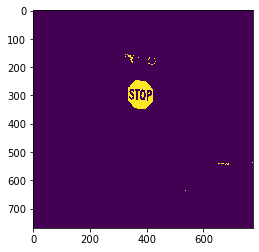

In [42]:
my_detector = StopSignDetector()
image = cv2.imread("/Users/hebolin/Downloads/ECE276A_PR12/hw1_starter_code/trainset/32.jpg")
mask= my_detector.segment_image(image)
box = my_detector.get_bounding_box(image)
pl.imshow(mask)

In [43]:
label_mask = label(mask, connectivity=2)
region = regionprops(label_mask)
x,y,z = image.shape
for i in range(len(region)):
    if region[i].extent >0.3 and region[i].extent < 0.7 and region[i].eccentricity>0.1 and region[i].eccentricity<0.9  and region[i].area/(x*y) > 0.003  and region[i].area > 45:
        a=i
        print(i)
        print(region[a].eccentricity,region[a].extent,region[a].area/(x*y))

41
0.5899213319212789 0.6063540419976063 0.009363239247311828


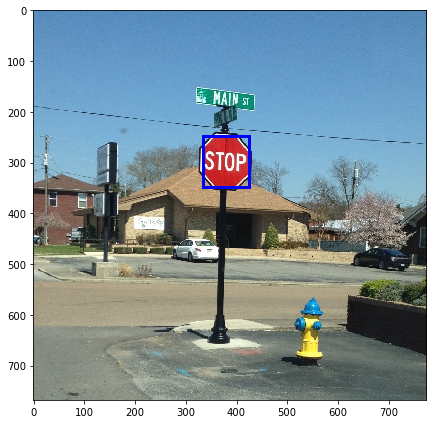

In [46]:
image3 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig,(ax0) = pl.subplots(1,1, figsize = (8,6))
ax0.imshow(image3)

minr1, minc1, maxr1, maxc1 = region[a].bbox
rect = pat.Rectangle((minc1, minr1), maxc1 - minc1, maxr1 - minr1,
                     fill=False, edgecolor='blue', linewidth=3)

# minr, minc, maxr, maxc = region[1479].bbox
# rect2 = pat.Rectangle((minc, minr), maxc - minc, maxr - minr,
#                      fill=False, edgecolor='blue', linewidth=3)
ax0.add_patch(rect)
# ax0.add_patch(rect2)

fig.tight_layout()
plt.show()

In [ ]:
img = cv2.imread("/Users/hebolin/PycharmProjects/ece271_hw1/testset/6.jpg")
image2 = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
x,y,z = image2.shape
data = image2.reshape(3,x*y)
mask = np.zeros((x*y),dtype = np.uint8) 
# mask = np.zeros([x,y],dtype = np.uint8)

In [ ]:
def probability1(mean, cov, data):
        val = np.dot(-0.5 * (data - mean).T, np.linalg.inv(cov))
        val2 = (data - mean)
        val3 = np.zeros(data.shape[1])
        for i in range(data.shape[1]):
            val3[i] = np.dot(val[i,:],val2[:,i])
        val4 = (2 * np.pi) ** 3 * abs(np.linalg.det(cov))
        p = 1 / (val4 ** 0.5) * np.exp(val3)
        return p

In [ ]:
def get_bounding_box(img,mask_img):
        boxes, hierarchy = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print("Number of contours = "+str(len(boxes)))
        print(boxes[0])
        cv2.drawContours(img, boxes, -1, (0, 255, 0), 3)

        return boxes

In [ ]:
my_detector = StopSignDetector()
image = cv2.imread("/Users/hebolin/Downloads/ECE276A_PR12/hw1_starter_code/trainset/6.jpg")
x,y,z = image.shape
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
image3 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# pl.imshow(image2)
mask_img = my_detector.segment_image(image)
pl.imshow(mask_img)


In [ ]:
region = regionprops(label_mask)
for i in range(len(region)):
#     if
    print(i)

In [ ]:
region[0].bbox